In [1]:
!date

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns

from matplotlib.ticker import StrMethodFormatter

%matplotlib inline

Wed Apr 17 10:15:27 KST 2024


In [2]:
az.style.use("arviz-darkgrid")
plt.rcParams["figure.constrained_layout.use"] = False

In [3]:
try:
    df_all = pd.read_csv("../data/rugby.csv", index_col=0)
except:
    df_all = pd.read_csv(pm.get_data("rugby.csv"), index_col=0)

In [4]:
df_all.describe()

,home_score,away_score,year
count,60.000000,60.000000,60.000000
mean,23.500000,19.983333,2015.500000
std,14.019962,12.911028,1.127469
min,0.000000,0.000000,2014.000000
25%,16.000000,10.000000,2014.750000
50%,20.500000,18.000000,2015.500000
75%,27.250000,23.250000,2016.250000
max,67.000000,63.000000,2017.000000


In [5]:
# Let's look at the tail end of this dataframe
df_all.tail()

,home_team,away_team,home_score,away_score,year
55,Italy,France,18,40,2017
56,England,Scotland,61,21,2017
57,Scotland,Italy,29,0,2017
58,France,Wales,20,18,2017
59,Ireland,England,13,9,2017


In [6]:
df_all["difference"] = np.abs(df_all["home_score"] - df_all["away_score"])

Text(0, 0.5, 'Average (abs) point difference')

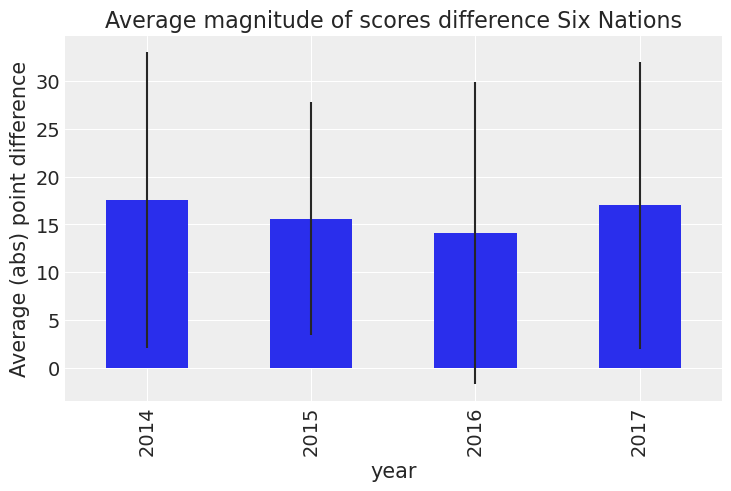

In [39]:
(df_all.groupby('year')['difference']
 .mean()
 .plot(
     kind = "bar"
     , title = "Average magnitude of scores difference Six Nations"
     , yerr = df_all.groupby('year')['difference'].std()
 )
 .set_ylabel("Average (abs) point difference")
 )

In [9]:
df_all["difference_non_abs"] = df_all["home_score"] - df_all["away_score"]
df_all.pivot_table("difference_non_abs", "home_team", "year")


year,2014,2015,2016,2017
home_team,,,,
England,7.000000,20.666667,7.500000,21.333333
France,6.666667,0.000000,-2.333333,4.000000
Ireland,28.000000,8.500000,17.666667,7.000000
Italy,-21.000000,-31.000000,-23.500000,-33.666667
Scotland,-11.000000,-12.000000,2.500000,16.666667
Wales,25.666667,1.000000,22.000000,4.000000


Text(0, 0.5, 'Score difference Home team and away team')

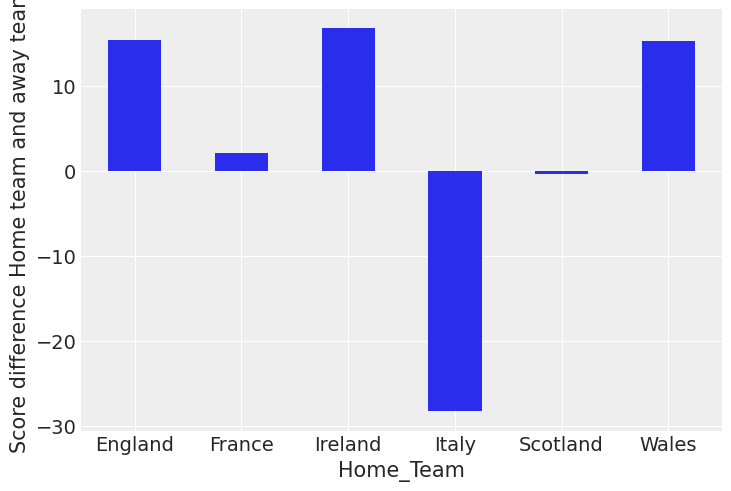

In [42]:
(df_all.pivot_table("difference_non_abs", "home_team")
 .rename_axis("Home_Team")
 .plot(kind = "bar", rot = 0, legend = False)
 .set_ylabel("Score difference Home team and away team")
 )


In [44]:
df_all.pivot_table("difference_non_abs", "away_team")

,difference_non_abs
away_team,
England,-10.2
France,2.8
Ireland,-6.8
Italy,24.2
Scotland,13.2
Wales,-2.1


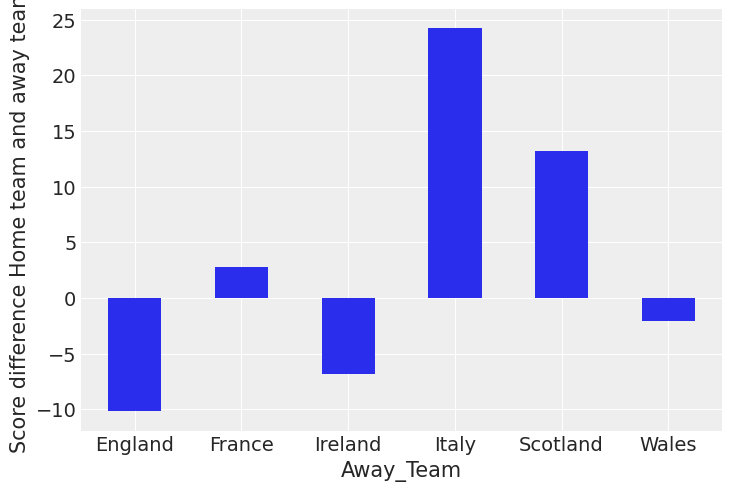

In [43]:
(
    df_all.pivot_table("difference_non_abs", "away_team")
    .rename_axis("Away_Team")
    .plot(kind="bar", rot=0, legend=False)
    .set_ylabel("Score difference Home team and away team")
);

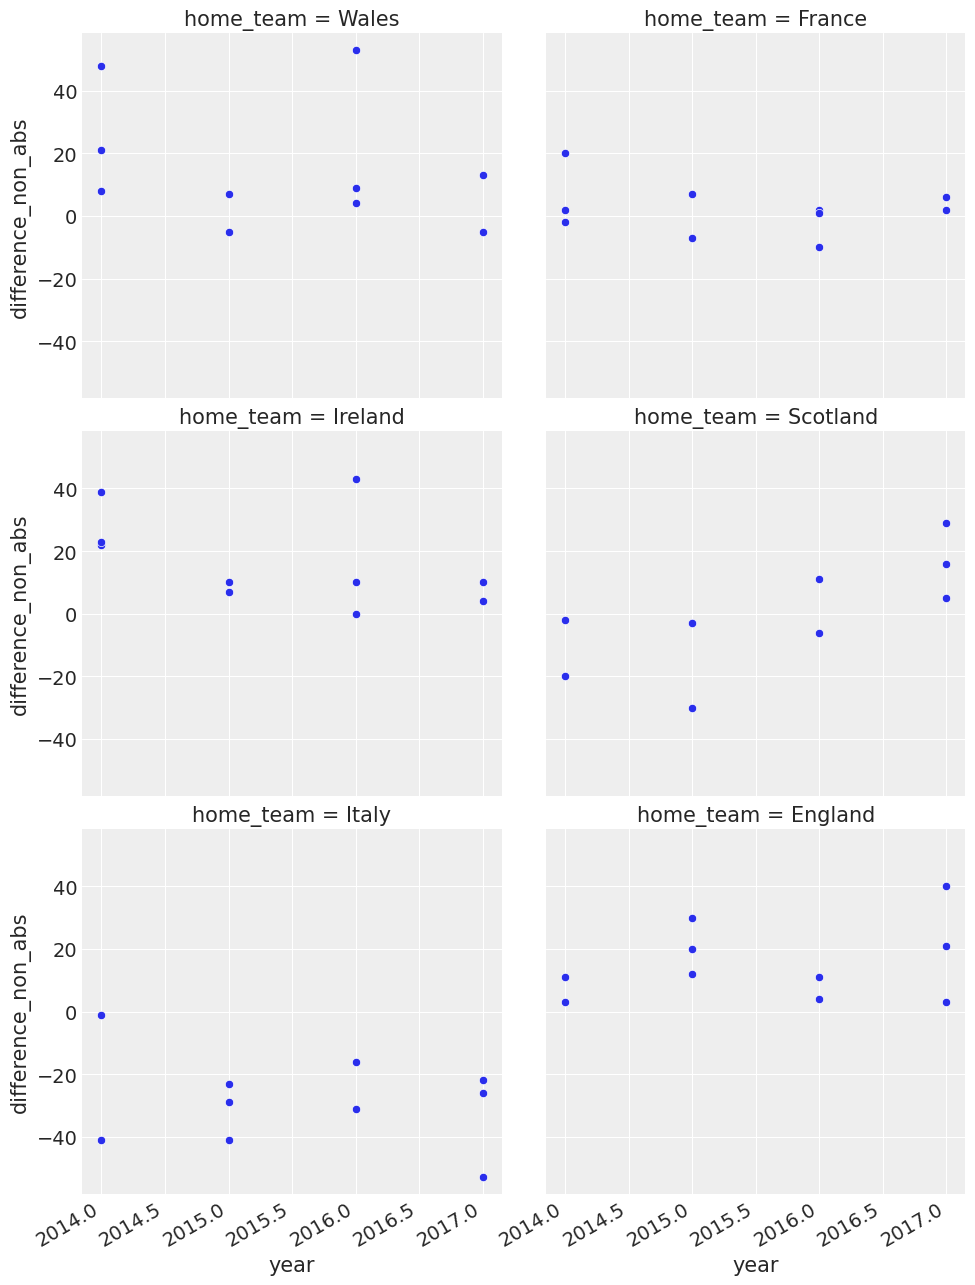

In [12]:
g = sns.FacetGrid(df_all, col="home_team", col_wrap=2, height=5)
g.map(sns.scatterplot, "year", "difference_non_abs")
g.figure.autofmt_xdate()

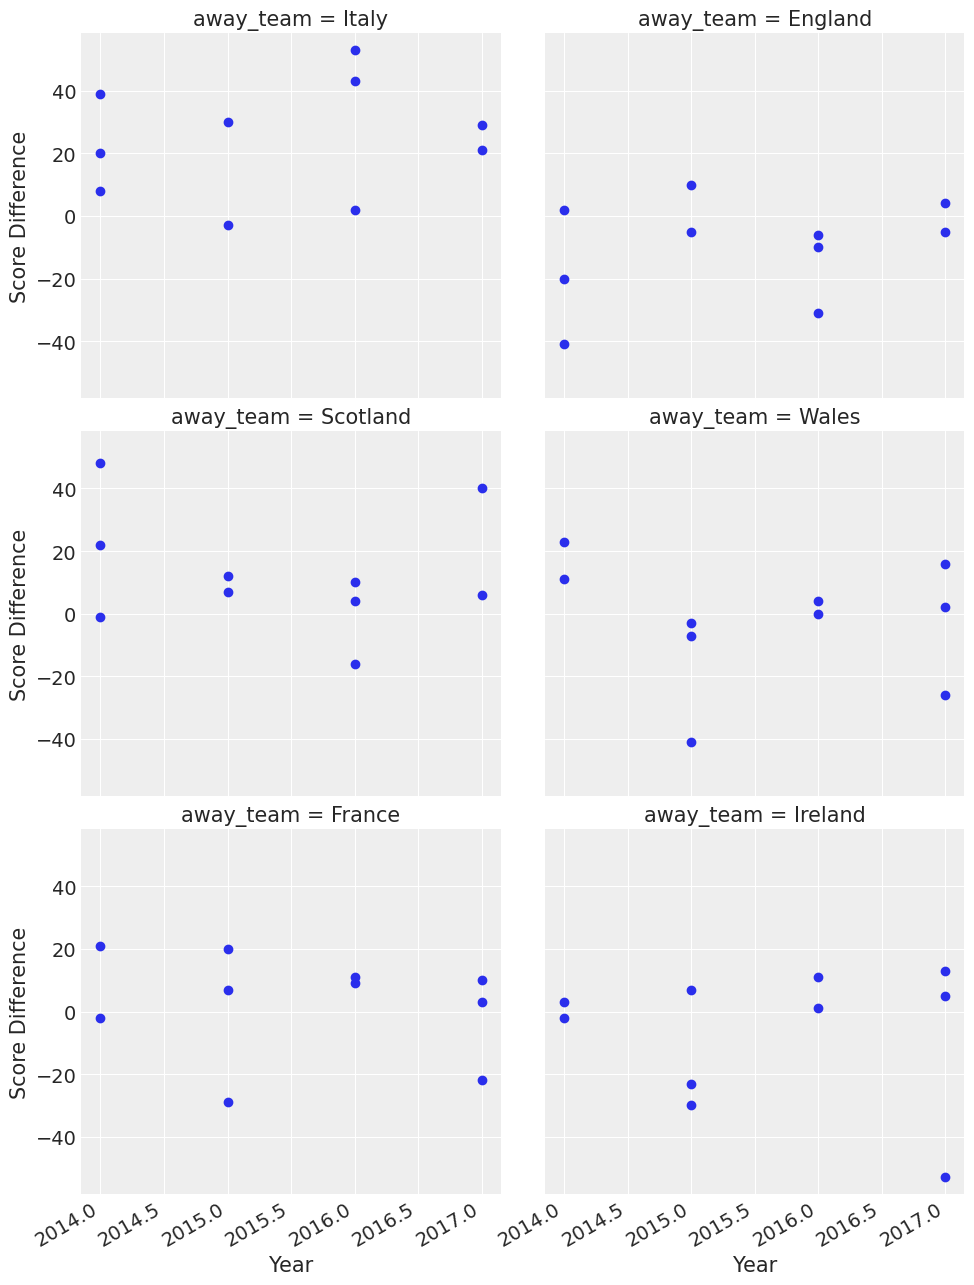

In [13]:
g = sns.FacetGrid(df_all, col="away_team", col_wrap=2, height=5)
g = g.map(plt.scatter, "year", "difference_non_abs").set_axis_labels("Year", "Score Difference")
g.figure.autofmt_xdate()

In [14]:
plt.rcParams["figure.constrained_layout.use"] = True
home_idx, teams = pd.factorize(df_all["home_team"], sort=True)
away_idx, _ = pd.factorize(df_all["away_team"], sort=True)
coords = {"team": teams}

In [15]:
with pm.Model(coords=coords) as model:
    # constant data
    home_team = pm.ConstantData("home_team", home_idx, dims="match")
    away_team = pm.ConstantData("away_team", away_idx, dims="match")

    # global model parameters
    home = pm.Normal("home", mu=0, sigma=1)
    sd_att = pm.HalfNormal("sd_att", sigma=2)
    sd_def = pm.HalfNormal("sd_def", sigma=2)
    intercept = pm.Normal("intercept", mu=3, sigma=1)

    # team-specific model parameters
    atts_star = pm.Normal("atts_star", mu=0, sigma=sd_att, dims="team")
    defs_star = pm.Normal("defs_star", mu=0, sigma=sd_def, dims="team")

    atts = pm.Deterministic("atts", atts_star - pt.mean(atts_star), dims="team")
    defs = pm.Deterministic("defs", defs_star - pt.mean(defs_star), dims="team")
    home_theta = pt.exp(intercept + home + atts[home_idx] + defs[away_idx])
    away_theta = pt.exp(intercept + atts[away_idx] + defs[home_idx])

    # likelihood of observed data
    home_points = pm.Poisson(
        "home_points",
        mu=home_theta,
        observed=df_all["home_score"],
        dims=("match"),
    )
    away_points = pm.Poisson(
        "away_points",
        mu=away_theta,
        observed=df_all["away_score"],
        dims=("match"),
    )
    trace = pm.sample(1000, tune=1500, cores=4)

/opt/homebrew/anaconda3/envs/BayesianInference/lib/python3.10/site-packages/pymc/data.py:273: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [home, sd_att, sd_def, intercept, atts_star, defs_star]


/opt/homebrew/anaconda3/envs/BayesianInference/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 6 seconds.


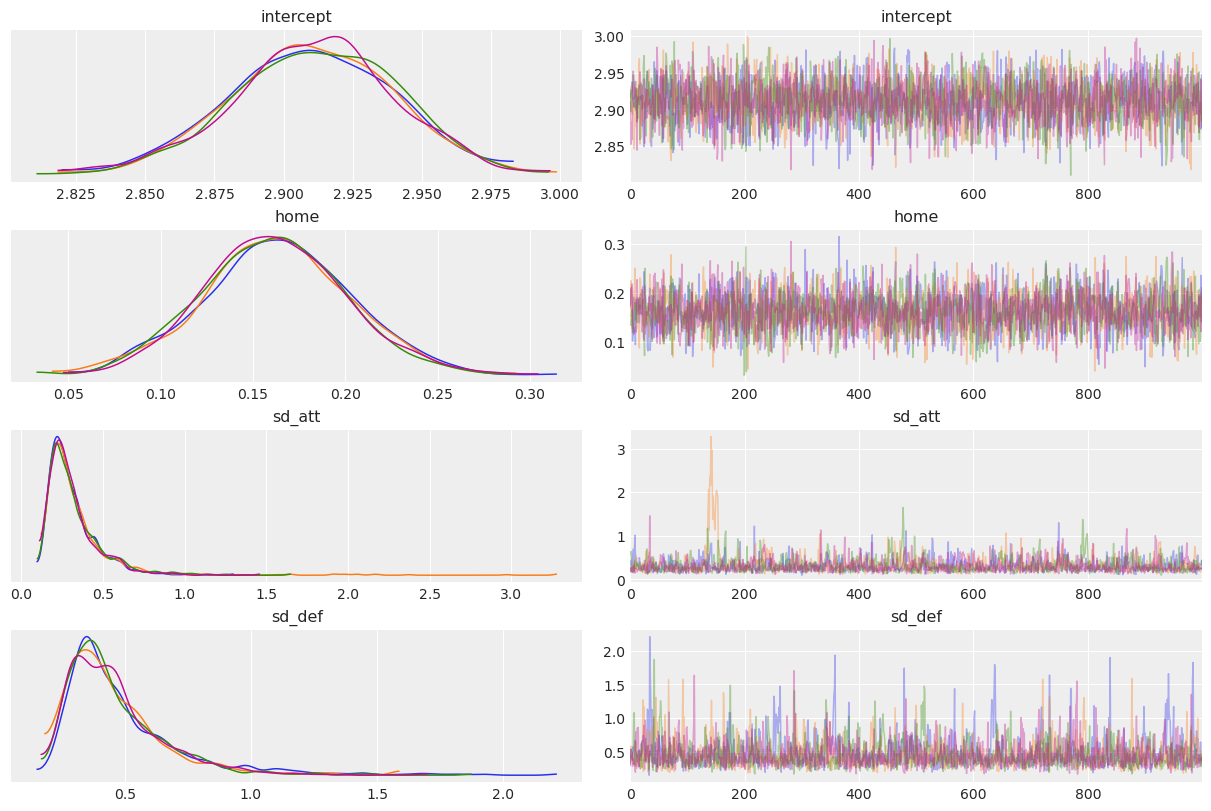

In [16]:
az.plot_trace(trace, var_names=["intercept", "home", "sd_att", "sd_def"], compact=False);

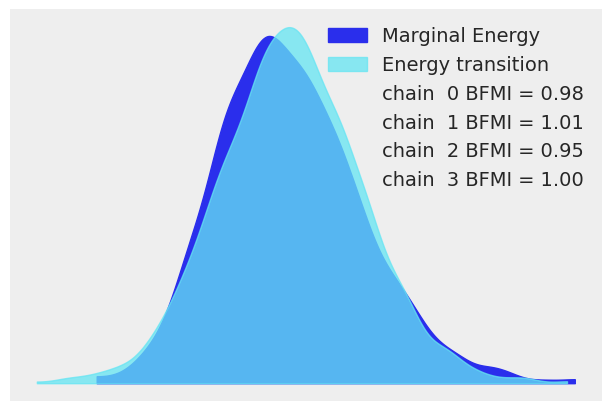

In [17]:
az.plot_energy(trace, figsize=(6, 4));

In [18]:
az.summary(trace, kind="diagnostics")

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
atts[England],0.001,0.000,4757.0,3058.0,1.00
atts[France],0.001,0.000,4932.0,2967.0,1.00
atts[Ireland],0.001,0.000,5178.0,3162.0,1.00
atts[Italy],0.001,0.001,4581.0,3045.0,1.00
atts[Scotland],0.001,0.000,5107.0,3271.0,1.00
atts[Wales],0.001,0.000,5378.0,3418.0,1.00
atts_star[England],0.008,0.007,1053.0,703.0,1.00
atts_star[France],0.008,0.008,1080.0,714.0,1.00
atts_star[Ireland],0.008,0.007,1079.0,666.0,1.00
atts_star[Italy],0.008,0.007,1113.0,707.0,1.00


In [19]:
trace_hdi = az.hdi(trace)
trace_hdi["atts"]

<xarray.DataArray 'atts' (team: 6, hdi: 2)> Size: 96B
array([[ 0.17926879,  0.32907237],
       [-0.16357845,  0.00094106],
       [ 0.02265002,  0.18113089],
       [-0.44068397, -0.22996532],
       [-0.20269408, -0.03036947],
       [ 0.0924334 ,  0.24813653]])
Coordinates:
  * team     (team) <U8 192B 'England' 'France' 'Ireland' ... 'Scotland' 'Wales'
  * hdi      (hdi) <U6 48B 'lower' 'higher'

In [20]:
trace.posterior["atts"].median(("chain", "draw"))

<xarray.DataArray 'atts' (team: 6)> Size: 48B
array([ 0.25682723, -0.08436102,  0.10913305, -0.33564434, -0.11600622,
        0.17275738])
Coordinates:
  * team     (team) <U8 192B 'England' 'France' 'Ireland' ... 'Scotland' 'Wales'

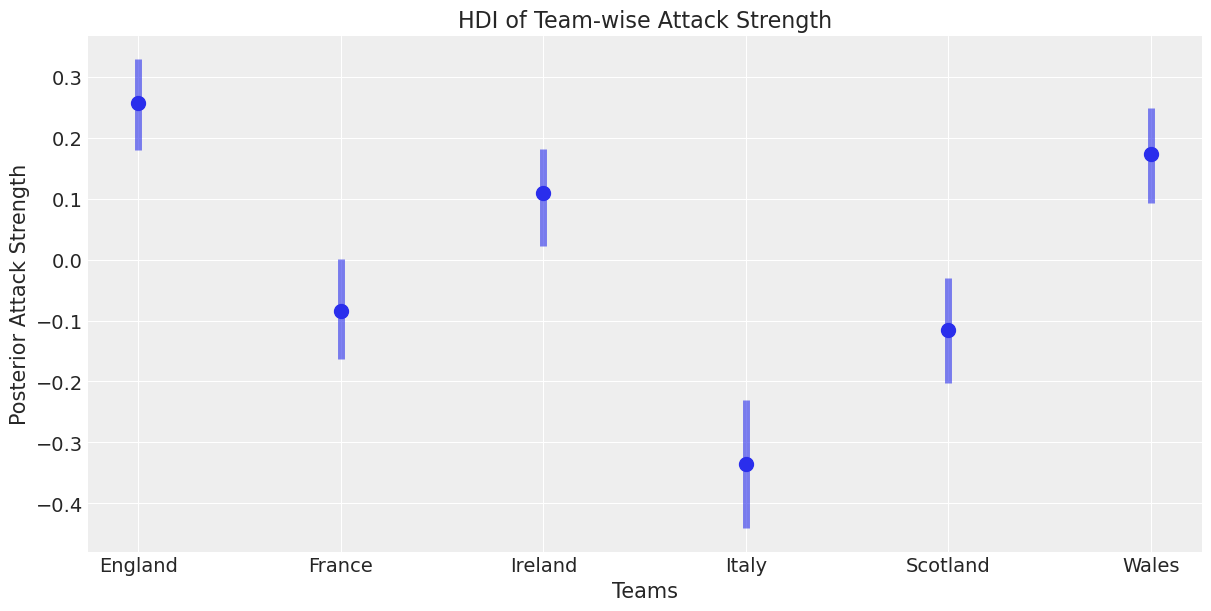

In [21]:
_, ax = plt.subplots(figsize=(12, 6))

ax.scatter(teams, trace.posterior["atts"].median(dim=("chain", "draw")), color="C0", alpha=1, s=100)
ax.vlines(
    teams,
    trace_hdi["atts"].sel({"hdi": "lower"}),
    trace_hdi["atts"].sel({"hdi": "higher"}),
    alpha=0.6,
    lw=5,
    color="C0",
)
ax.set_xlabel("Teams")
ax.set_ylabel("Posterior Attack Strength")
ax.set_title("HDI of Team-wise Attack Strength");

In [22]:
# subclass arviz labeller to omit the variable name
class TeamLabeller(az.labels.BaseLabeller):
    def make_label_flat(self, var_name, sel, isel):
        sel_str = self.sel_to_str(sel, isel)
        return sel_str

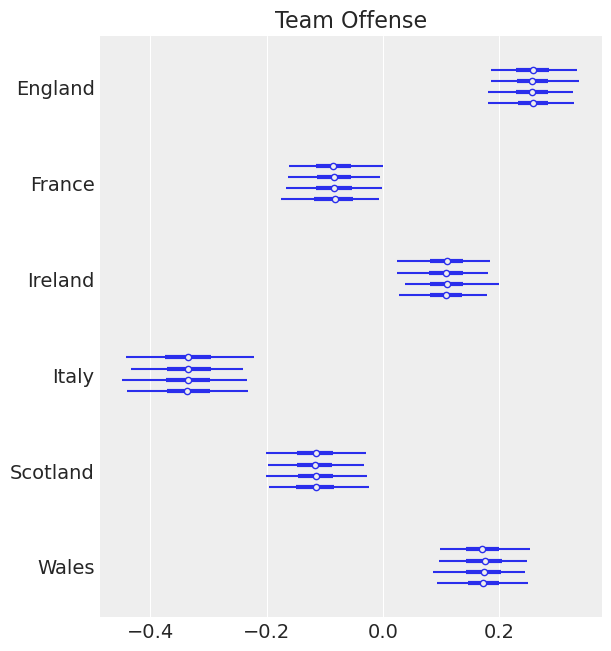

In [23]:
ax = az.plot_forest(trace, var_names=["atts"], labeller=TeamLabeller())
ax[0].set_title("Team Offense");

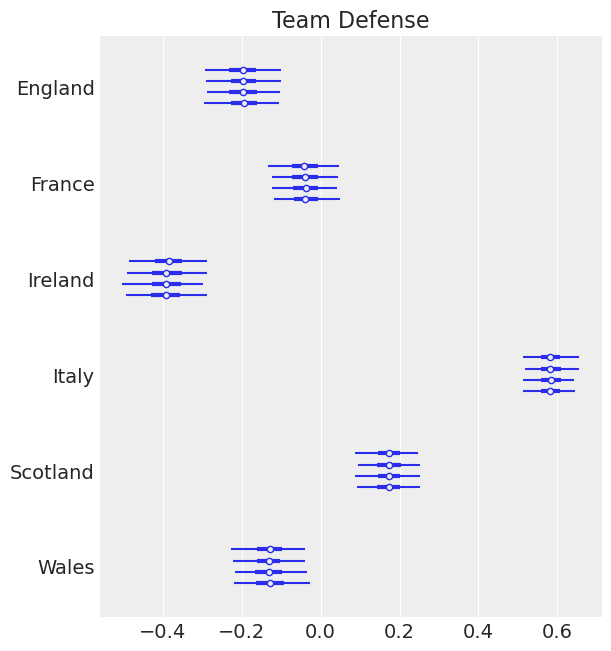

In [24]:
ax = az.plot_forest(trace, var_names=["defs"], labeller=TeamLabeller())
ax[0].set_title("Team Defense");

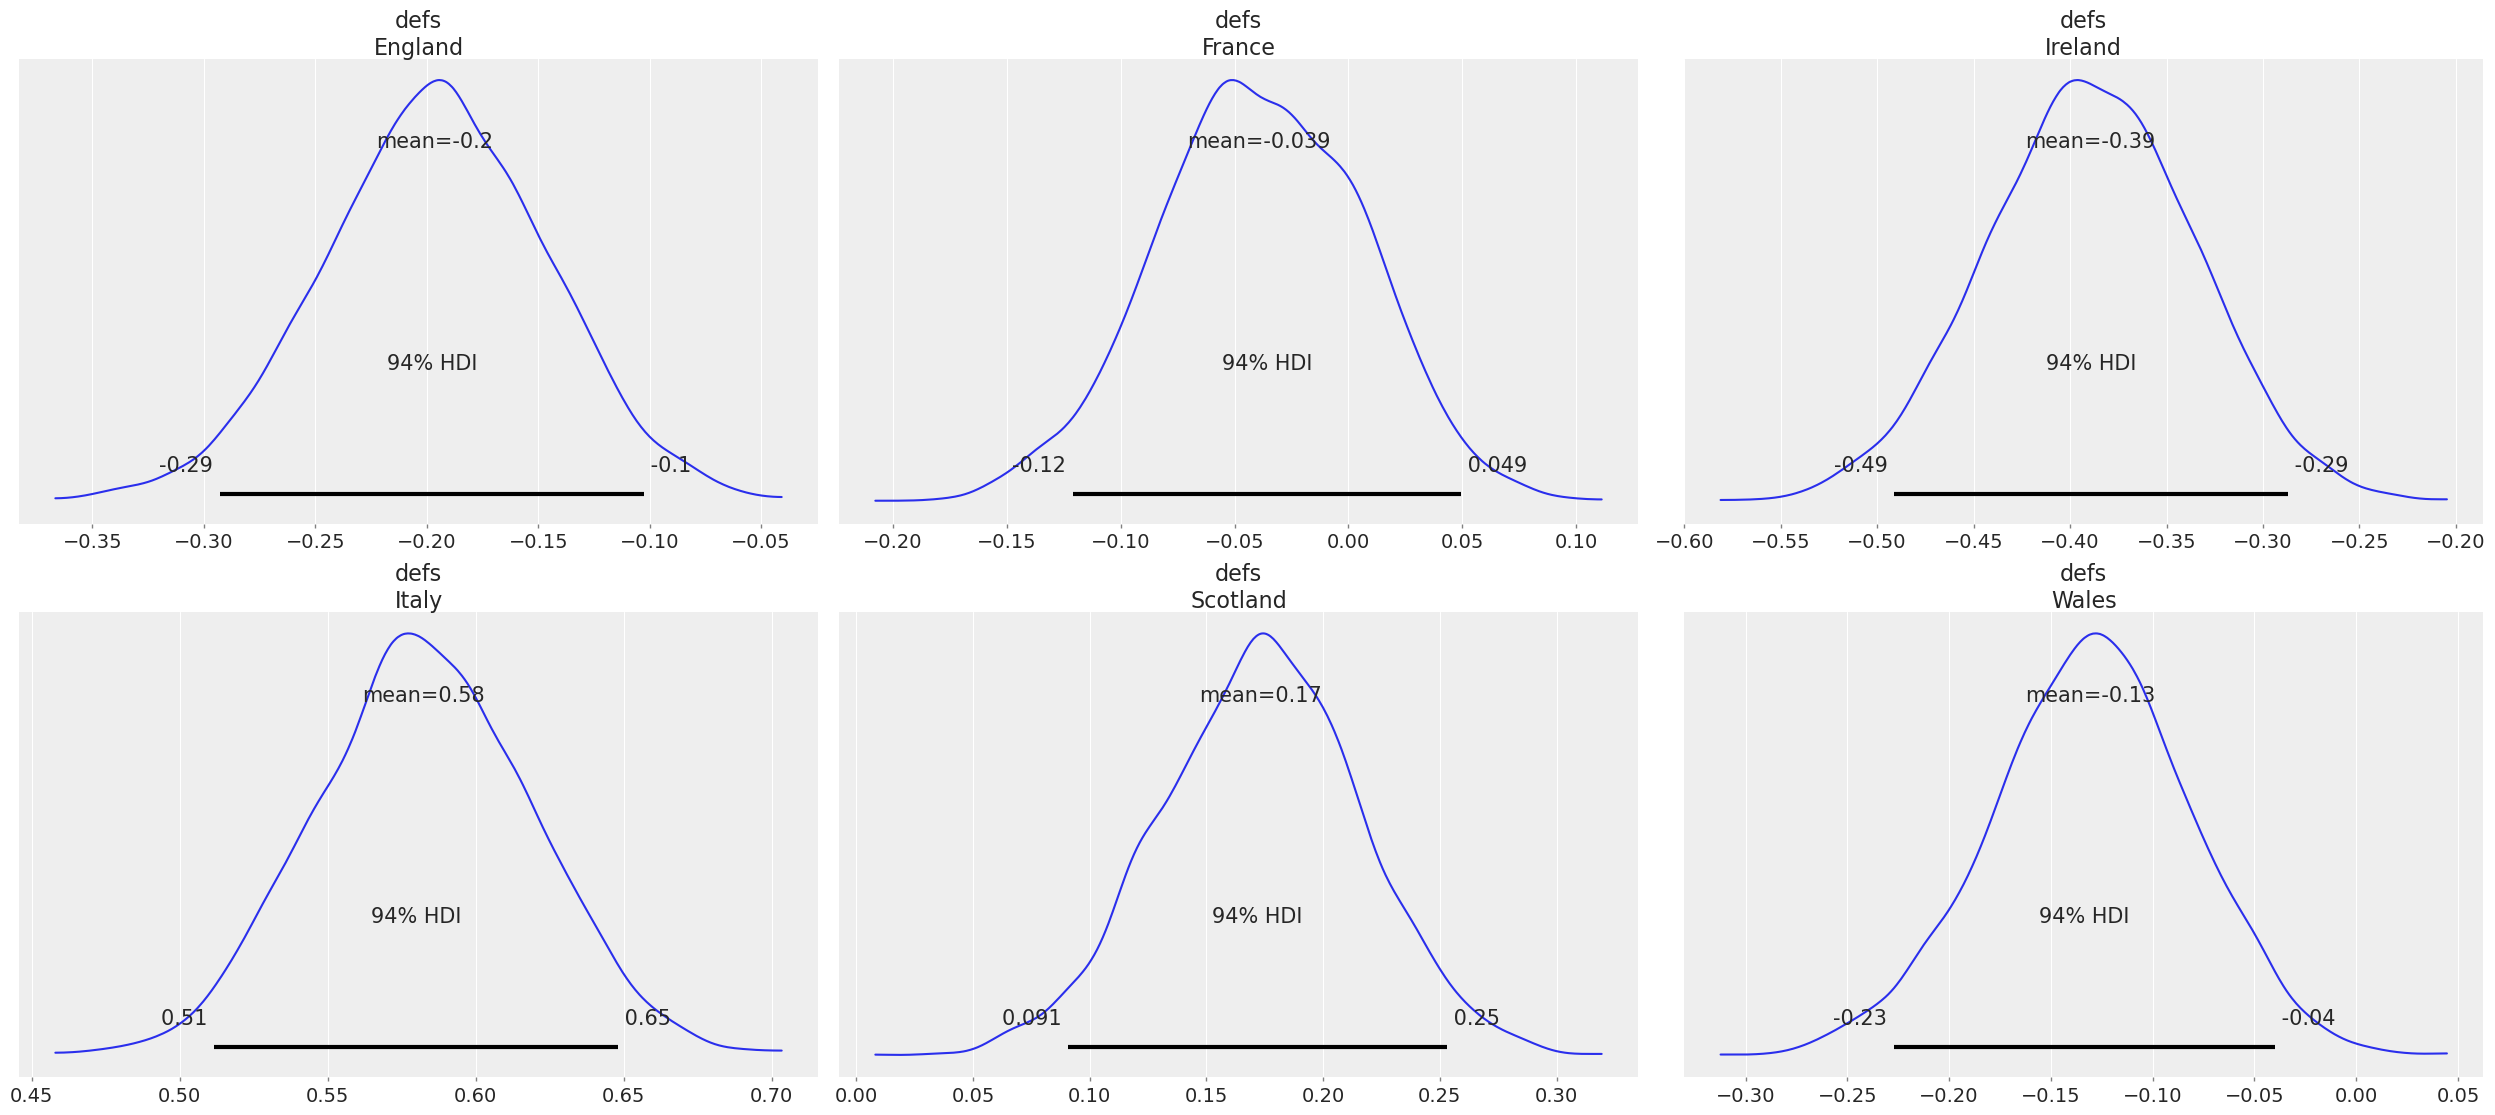

In [25]:
az.plot_posterior(trace, var_names=["defs"]);

In [26]:
with model:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)
pp = trace.posterior_predictive
const = trace.constant_data
team_da = trace.posterior.team

Sampling: [away_points, home_points]


/opt/homebrew/anaconda3/envs/BayesianInference/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [27]:
# fmt: off
pp["home_win"] = (
    (pp["home_points"] > pp["away_points"]) * 3     # home team wins and gets 3 points
    + (pp["home_points"] == pp["away_points"]) * 2  # tie -> home team gets 2 points
)
pp["away_win"] = (
    (pp["home_points"] < pp["away_points"]) * 3
    + (pp["home_points"] == pp["away_points"]) * 2
)
# fmt: on

In [28]:
groupby_sum_home = pp.home_win.groupby(team_da[const.home_team]).sum()
groupby_sum_away = pp.away_win.groupby(team_da[const.away_team]).sum()

pp["teamscores"] = groupby_sum_home + groupby_sum_away

In [29]:
from xarray_einstats.stats import rankdata

pp["rank"] = rankdata(-pp["teamscores"], dims="team", method="min")
pp[["rank"]].sel(team="England")

<xarray.Dataset> Size: 40kB
Dimensions:  (chain: 4, draw: 1000)
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
    team     <U7 28B 'England'
Data variables:
    rank     (chain, draw) int64 32kB 2 1 1 1 2 1 1 2 1 2 ... 2 1 3 1 3 2 2 2 1
Attributes:
    created_at:                 2024-04-17T01:19:23.247161+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.13.0

In [31]:
from xarray_einstats.numba import histogram

bin_edges = np.arange(7) + 0.5
data_sim = (
    histogram(pp["rank"], dims=("chain", "draw"), bins=bin_edges, density=True)
    .rename({"bin": "rank"})
    .assign_coords(rank=np.arange(6) + 1)
)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [32]:
idx_dim, col_dim = data_sim.dims
sim_table = pd.DataFrame(data_sim, index=data_sim[idx_dim], columns=data_sim[col_dim])

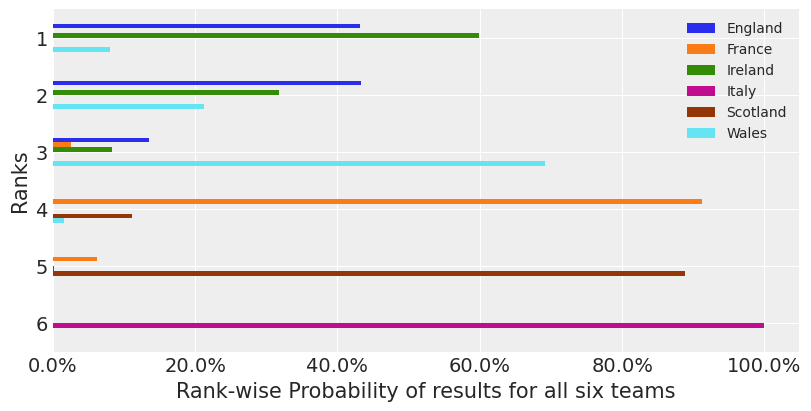

In [33]:
fig, ax = plt.subplots(figsize=(8, 4))
ax = sim_table.T.plot(kind="barh", ax=ax)
ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.1%}"))
ax.set_xlabel("Rank-wise Probability of results for all six teams")
ax.set_yticklabels(np.arange(1, 7))
ax.set_ylabel("Ranks")
ax.invert_yaxis()
ax.legend(loc="best", fontsize="medium");

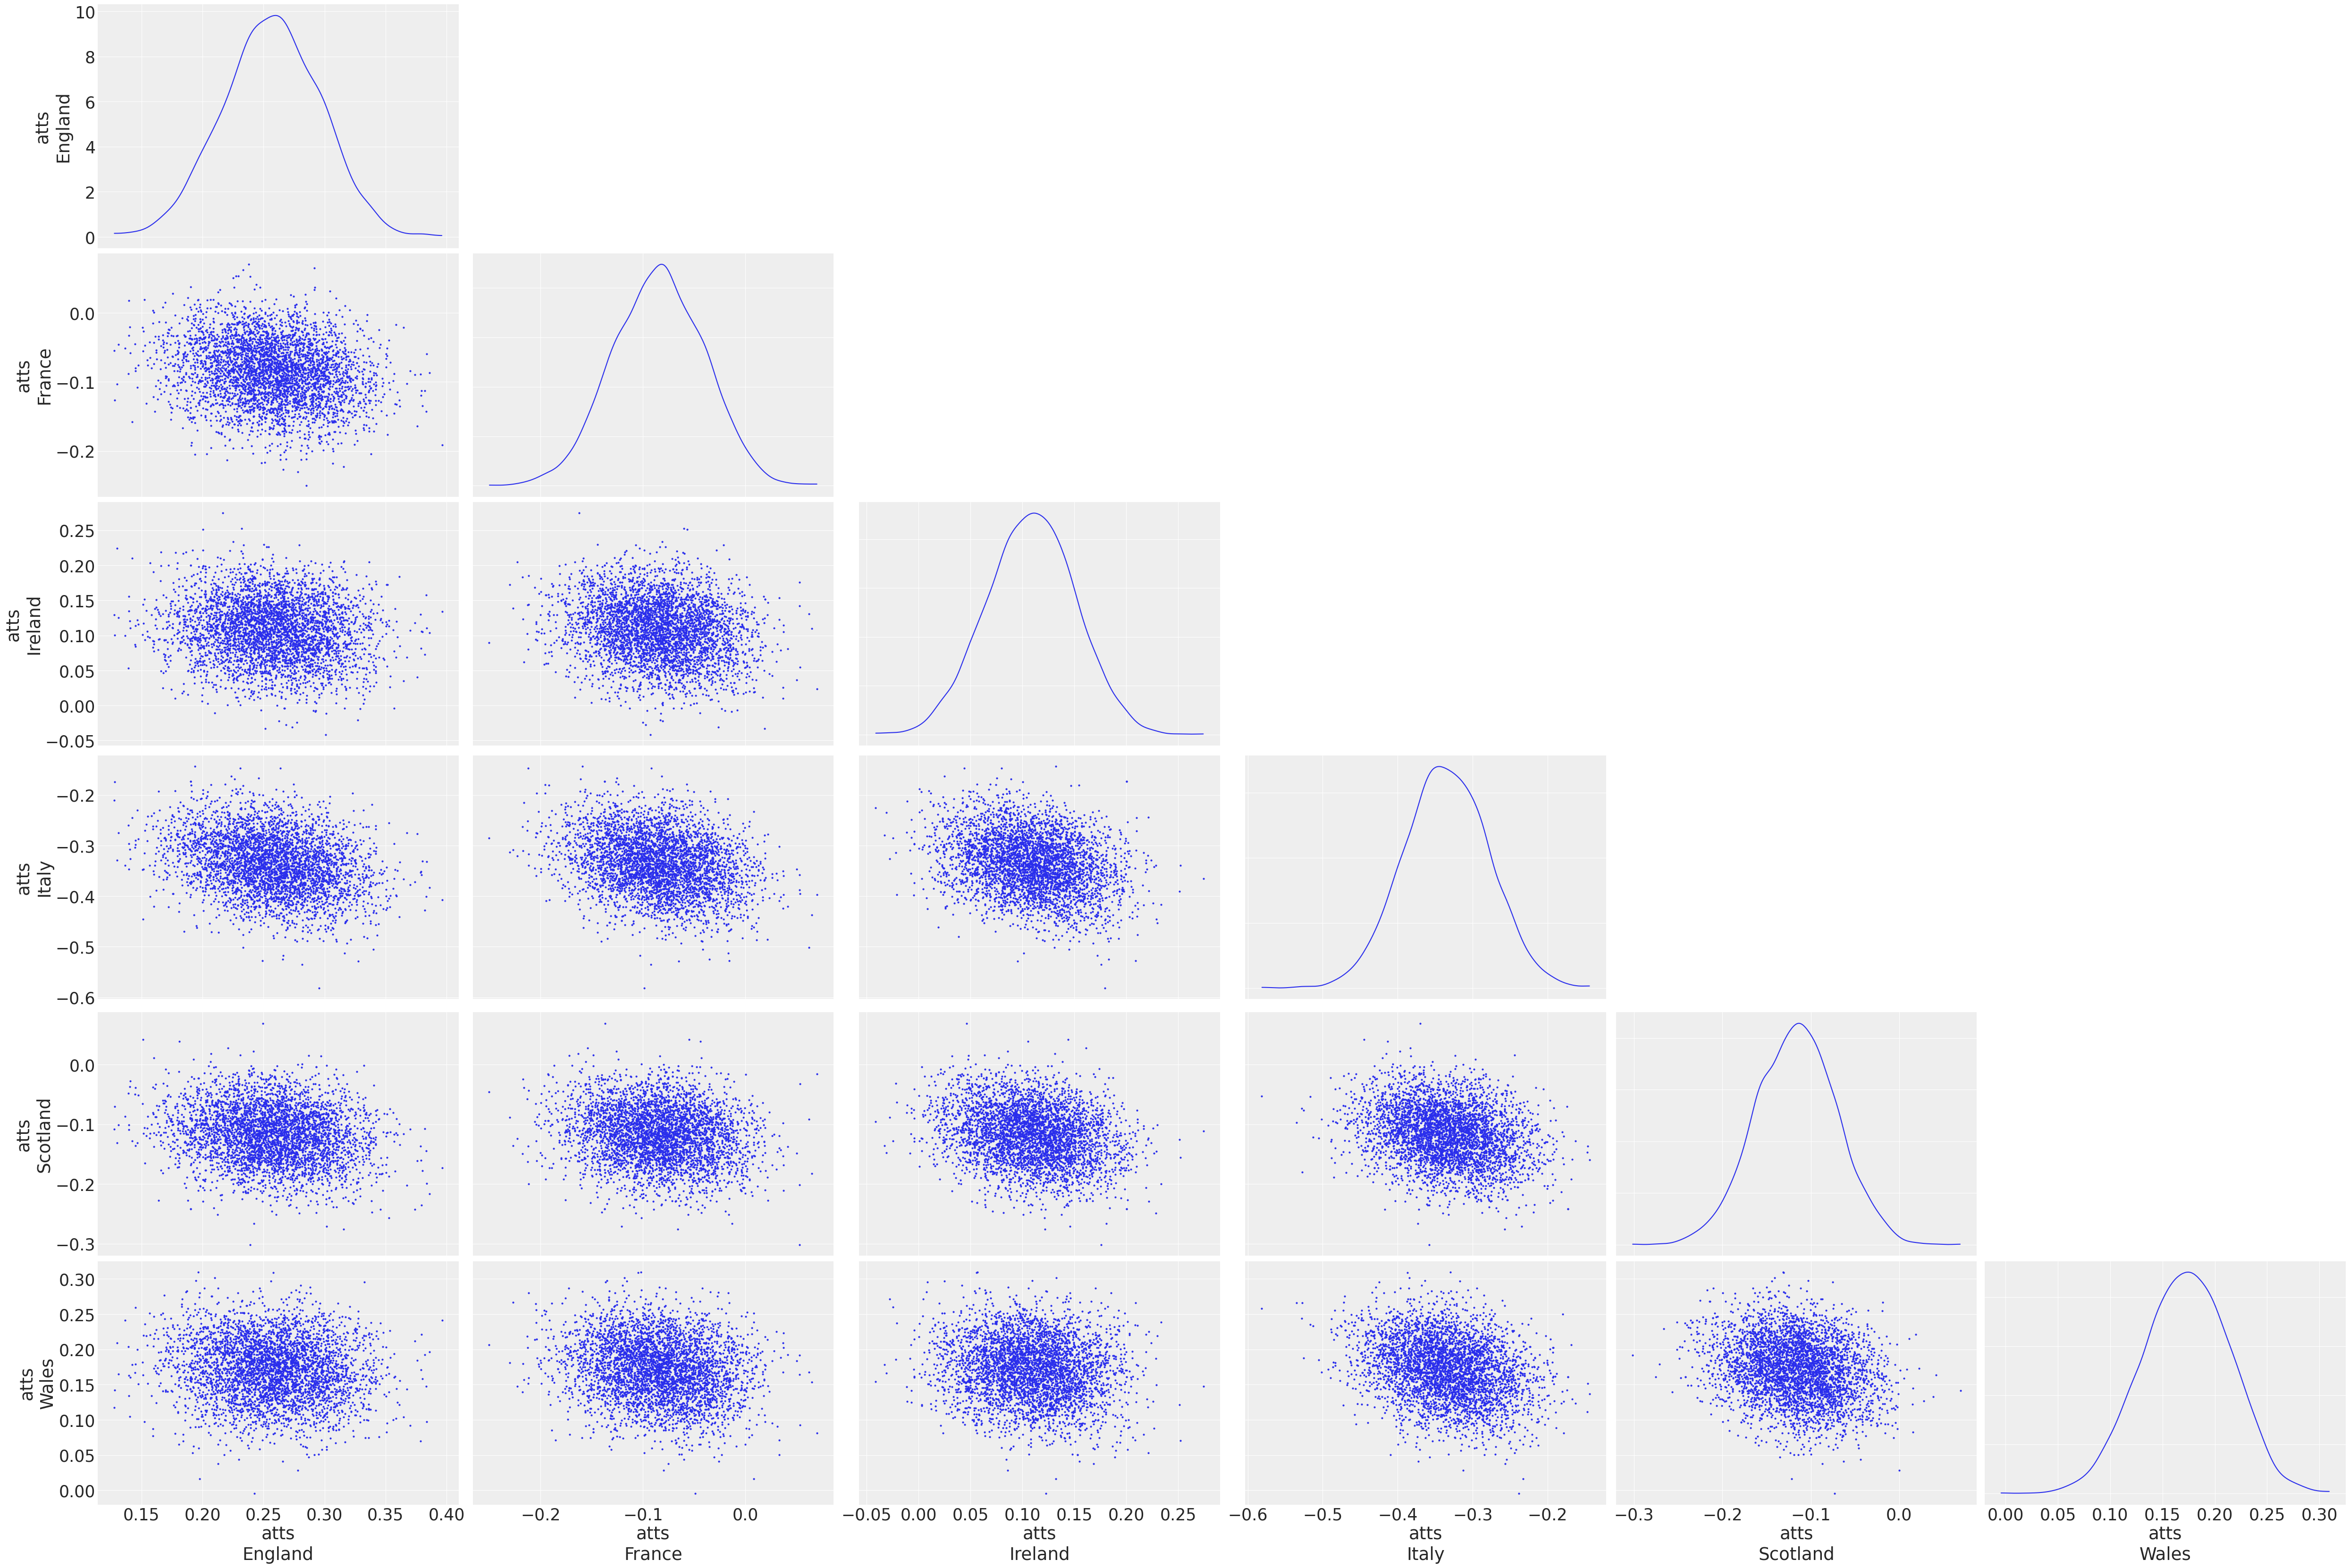

In [34]:
az.plot_pair(
    trace,
    var_names=["atts"],
    kind="scatter",
    divergences=True,
    textsize=25,
    marginals=True,
),
figsize = (10, 10)